In [345]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
import xgboost as xgb


In [346]:
train = pd.read_csv('train.csv')
gS = pd.read_csv('gender_submission.csv')
test = pd.read_csv('test.csv')

dropCols = ["Name", "Ticket", "Cabin"]

train = train.drop(columns=dropCols)
test = test.drop(columns=dropCols)

train = pd.get_dummies(train, columns=["Embarked", "Sex"])
test = pd.get_dummies(test, columns=["Embarked", "Sex"])

#print(train.head())

test = test.reindex(columns=train.drop(columns=["Survived"]).columns, fill_value=0)

X = train.drop(columns=["Survived", "PassengerId"])
y = train["Survived"]
X_test_modded = test.drop(columns=["PassengerId"])
#X = pd.DataFrame(train, columns = ["PassengerId", "Pclass","Age", "SibSp", "Parch", "Fare", "Embarked_C", "Embarked_Q", "Embarked_S", "Sex_female", "Sex_male"])


#print(X.tail())
#print(train[["Embarked_C", "Embarked_Q", "Embarked_S"]].head(10))

In [347]:

X_train, X_test, y_train, y_test = tts(X,y, test_size=0.25, random_state=42)

model = xgb.XGBClassifier( #classification model under XGBoost
    n_estimators = 300,
    learning_rate = 0.05,
    max_depth = 5,
    subsample = 0.6,
    colsample_bytree = 0.8,
    eval_metric = 'logloss'
)

model.fit(X_train, y_train)

test_score = model.score(X_test, y_test)
print(f"Initial test/trained score: {test_score*100:.2f}%")
preds = model.predict_proba(X_test_modded)[:,1]
customPreds = (preds >= .7).astype(int)

model.fit(X, y)
fullModelScore = model.score(X, y)
print(f"Full model score on all (Test) data: {fullModelScore*100:.2f}%")
predsFull = model.predict_proba(X_test_modded)[:,1]
customPredsFull = (predsFull >= .7).astype(int)


import sklearn.metrics as metrics

accuracy = metrics.accuracy_score(gS["Survived"], customPredsFull)
print(f"Accuracy compared to actual results: {accuracy*100:.2f}%")

from sklearn.datasets import make_regression
from xgboost import XGBRegressor

regModel = XGBRegressor( #regression model to compare
    n_estimators = 300,
    learning_rate = 0.05,
    max_depth = 5,
    subsample = 0.6,
    colsample_bytree = 0.8,
)
regModel.fit(X, y)
regScore = regModel.score(X_test, y_test)
print(f"Regression model score: {regScore*100:.2f}%")
regPreds = regModel.predict(X_test_modded)
regModelPreds = (regPreds >= .7).astype(int)
regAccuracy = metrics.accuracy_score(gS["Survived"], regModelPreds)
print(f"Regression model accuracy compared to actual results: {regAccuracy*100:.2f}%")

Initial test/trained score: 80.72%
Full model score on all (Test) data: 92.14%
Accuracy compared to actual results: 85.17%
Regression model score: 83.93%
Regression model accuracy compared to actual results: 84.21%


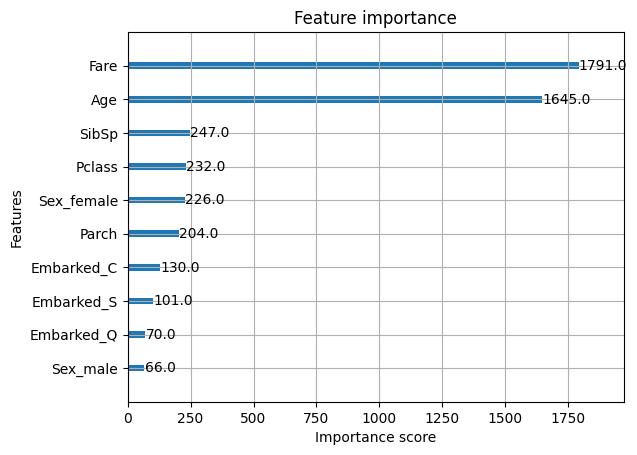

In [348]:
xgb.plot_importance(model)
plt.show()

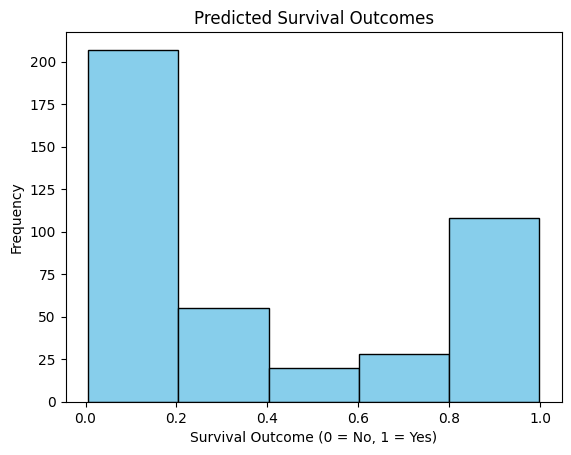

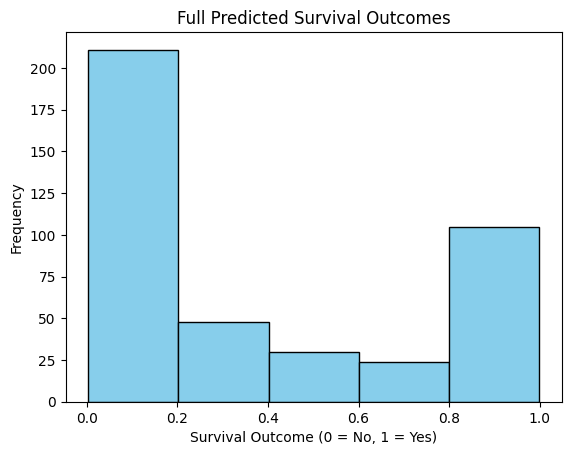

In [349]:
plt.hist(preds, bins = 5, color = 'skyblue', edgecolor = 'black')
plt.title('Predicted Survival Outcomes')
plt.xlabel('Survival Outcome (0 = No, 1 = Yes)')
plt.ylabel('Frequency')
plt.show() #rip

plt.hist(predsFull, bins = 5, color = 'skyblue', edgecolor = 'black')
plt.title('Full Predicted Survival Outcomes')
plt.xlabel('Survival Outcome (0 = No, 1 = Yes)')
plt.ylabel('Frequency')
plt.show() #rip

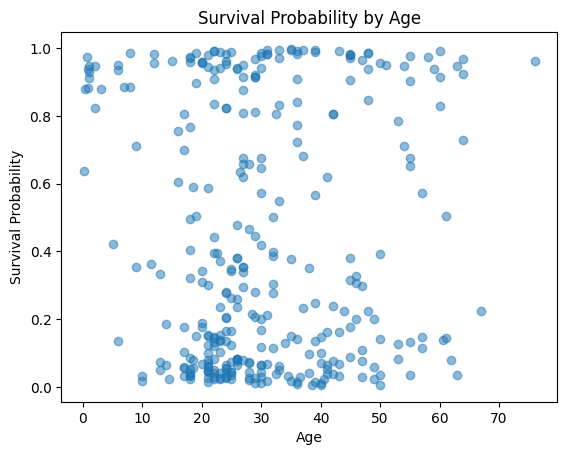

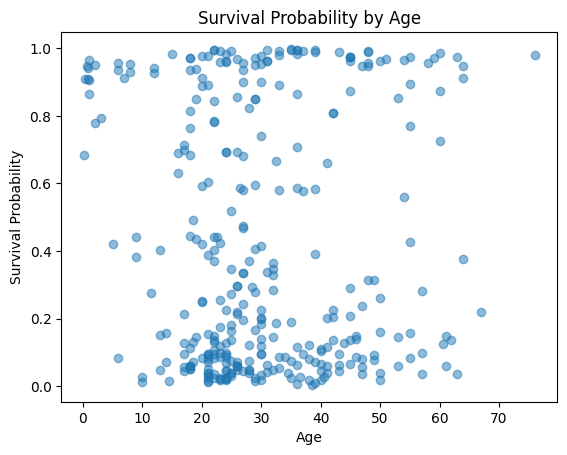

In [350]:
plt.scatter(test["Age"], preds, alpha=0.5)
plt.title("Survival Probability by Age")
plt.xlabel("Age")
plt.ylabel("Survival Probability")
plt.show()

plt.scatter(test["Age"], predsFull, alpha=0.5)
plt.title("Survival Probability by Age")
plt.xlabel("Age")
plt.ylabel("Survival Probability")
plt.show()

In [351]:
import statsmodels.api as sm

X_sm = X.select_dtypes(include=[np.number])
X_sm = X_sm.apply(pd.to_numeric, errors='coerce')
X_sm = X_sm.fillna(X_sm.mean())
X_sm = sm.add_constant(X_sm)

ols_model = sm.OLS(y, X_sm).fit()
print(ols_model.summary()) #regression model under statsmodels

print("\n\n")

logit_model = sm.Logit(y, X_sm).fit()
print(logit_model.summary()) #logistic regression model under statsmodels

                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     34.89
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           1.27e-32
Time:                        03:51:50   Log-Likelihood:                -541.81
No. Observations:                 891   AIC:                             1096.
Df Residuals:                     885   BIC:                             1124.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0683      0.081     13.207      0.0